# London Fire Incidents Dimensionality Reduction

In [1]:
%matplotlib inline 
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Downloading and loadng the data

In [2]:
# Loading the data
# import data_download

data_dir = "LFB-data"
# LFB_data = pd.read_csv(os.path.join(data_dir, "LFB Incident data - Datastore - with notional cost and UPRN from January 2009.csv"))
LFB_data = pd.read_csv(os.path.join(data_dir, "lfb_incident.csv"))

# Total memory used
print(f'Total Memory Used : {round(LFB_data.memory_usage(deep=True).sum()/(1024*1024), 2)} MB')
LFB_data.head()

Total Memory Used : 1486.66 MB


,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,...,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls
0,235138081,1-Jan-09,2009,0:00:37,0,Special Service,Special Service,RTC,Road Vehicle,Car,...,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,1.0,255.0,1.0
1,1091,1-Jan-09,2009,0:00:46,0,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2091,1-Jan-09,2009,0:03:00,0,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,...,308.0,Edmonton,NaN,NaN,1.0,1.0,1.0,1.0,255.0,2.0
3,3091,1-Jan-09,2009,0:04:27,0,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),...,210.0,Hillingdon,NaN,NaN,1.0,1.0,1.0,1.0,255.0,2.0
4,5091,1-Jan-09,2009,0:05:39,0,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,...,233.0,Holloway,250.0,Holloway,1.0,2.0,2.0,1.0,255.0,1.0


### Primary Data analysis

In [3]:
LFB_data.shape

(1048575, 39)

In [4]:
LFB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 39 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   IncidentNumber                          1048575 non-null  object 
 1   DateOfCall                              1048575 non-null  object 
 2   CalYear                                 1048575 non-null  int64  
 3   TimeOfCall                              1048575 non-null  object 
 4   HourOfCall                              1048575 non-null  int64  
 5   IncidentGroup                           1048575 non-null  object 
 6   StopCodeDescription                     1048575 non-null  object 
 7   SpecialServiceType                      318402 non-null   object 
 8   PropertyCategory                        1048575 non-null  object 
 9   PropertyType                            1048575 non-null  object 
 10  AddressQualifier              

We can see that there are missing values

## Exploratory data analysis

### Numerical data

In [5]:
# select numeric columns
df_numeric = LFB_data.select_dtypes(include=[np.number])

print("Numeric data shape : ",df_numeric.shape)
df_numeric.columns.values

Numeric data shape :  (1048575, 18)


array(['CalYear', 'HourOfCall', 'UPRN', 'USRN', 'Easting_m', 'Northing_m',
       'Easting_rounded', 'Northing_rounded', 'Latitude', 'Longitude',
       'FirstPumpArriving_AttendanceTime',
       'SecondPumpArriving_AttendanceTime',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls'], dtype=object)

In [6]:
df_numeric.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

,count,mean,std,min,25%,50%,75%,max
CalYear,1048575.00,2013.07,2.84,2009.00,2011.00,2013.00,2016.00,2018.00
HourOfCall,1048575.00,13.53,6.22,0.00,9.00,14.00,19.00,23.00
UPRN,907242.00,23843843874.00,49523278512.81,0.00,0.00,0.00,10022800743.00,200004000000.00
USRN,885704.00,20230482.00,4235058.73,0.00,20400898.00,21201309.00,22102010.00,99990116.00
Easting_m,567324.00,530635.68,10284.48,503588.00,525304.00,530777.00,536760.00,560925.00
Northing_m,567324.00,180376.97,7403.76,156761.00,176063.00,180991.00,184884.00,200906.00
Easting_rounded,1048575.00,530684.89,9717.39,503550.00,525350.00,530950.00,536250.00,560950.00
Northing_rounded,1048575.00,180522.81,7305.33,156650.00,176250.00,181050.00,185150.00,200950.00
Latitude,567324.00,51.51,0.17,0.00,51.47,51.51,51.55,51.69
Longitude,567324.00,-0.12,0.15,-0.51,-0.20,-0.12,-0.03,0.32


We can tell from the data above that there are outliers in the numeric data.
For instance, there are values that have a very huge diffrence between the 75th percentile and maximum value

#### Numerical data visualization

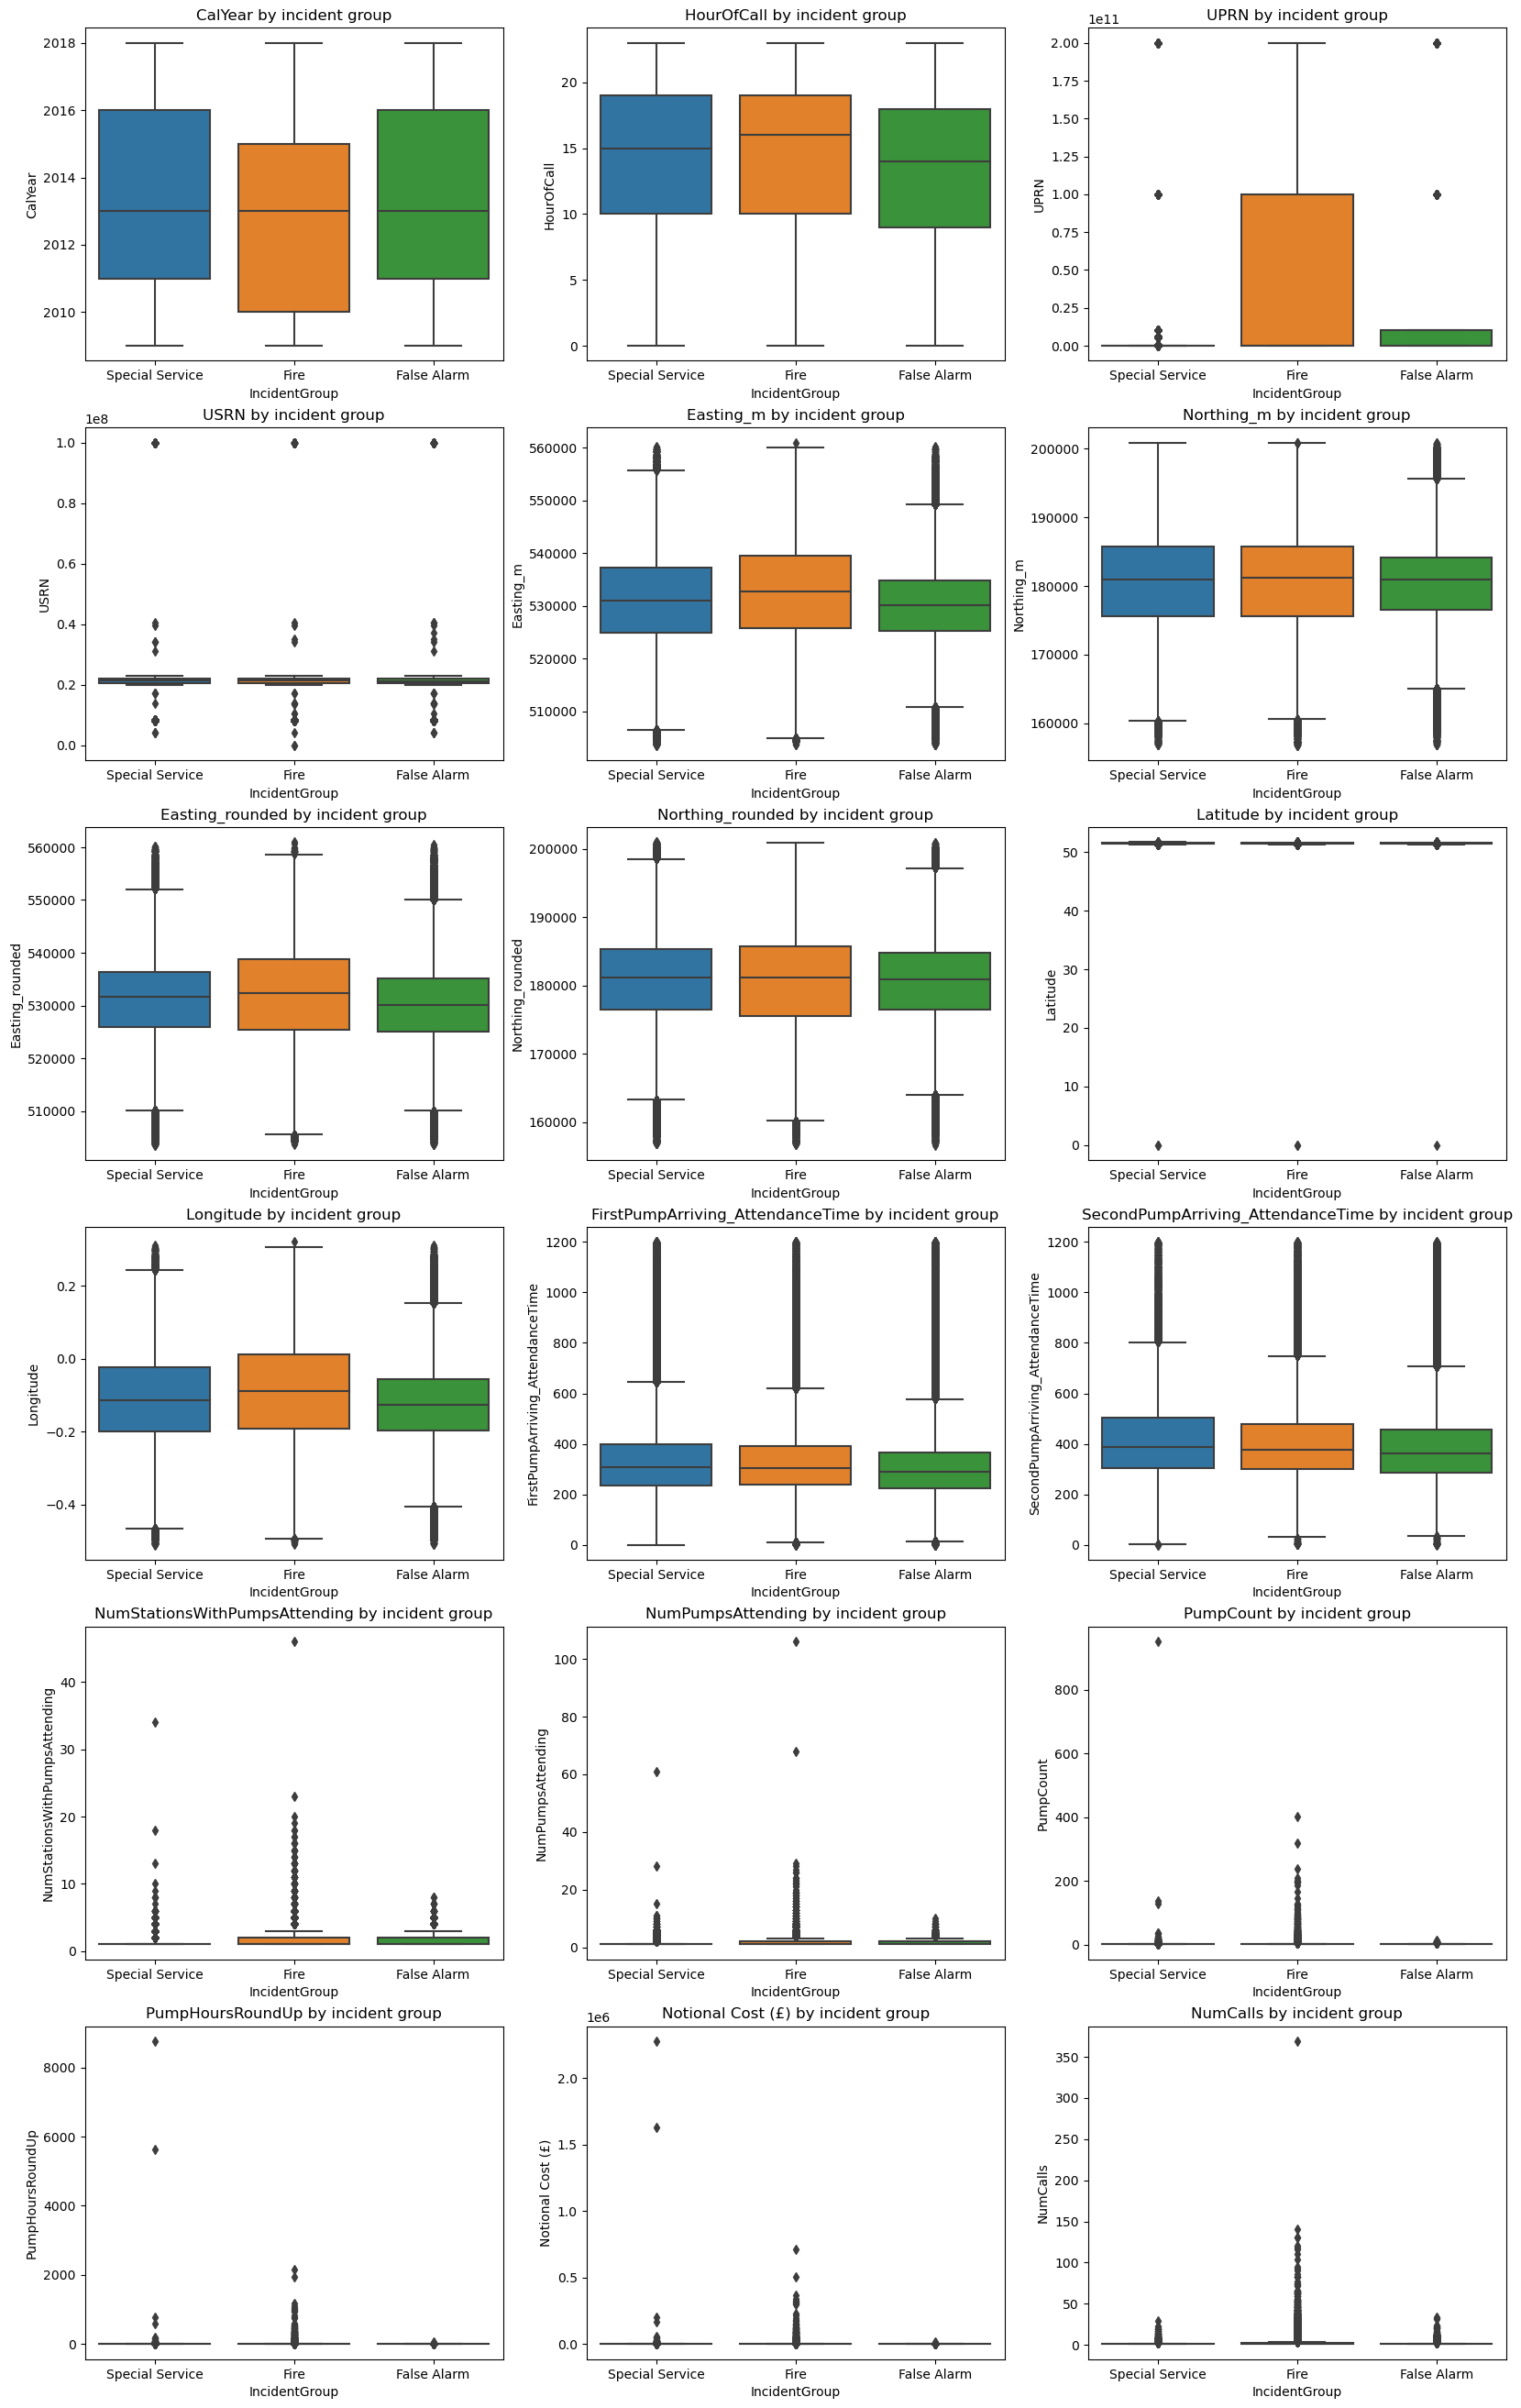

In [7]:
fig = plt.figure(figsize= (20,50))

for i in range(len(df_numeric.columns)):
    column = df_numeric.columns[i]
    sub = fig.add_subplot(9,3, i+1)
    chart = sns.boxplot(data=df_numeric, y=column, x = LFB_data["IncidentGroup"])
    chart.set_title(column + " by incident group")

#### Missing values on Numeric data

In [8]:
# Check for any missing values
print("Number of cols with Missing Vals: ",df_numeric.isna().any().sum())
display(df_numeric.isna().sum())

Number of cols with Missing Vals:  14


CalYear                                   0
HourOfCall                                0
UPRN                                 141333
USRN                                 162871
Easting_m                            481251
Northing_m                           481251
Easting_rounded                           0
Northing_rounded                          0
Latitude                             481251
Longitude                            481251
FirstPumpArriving_AttendanceTime      95155
SecondPumpArriving_AttendanceTime    680132
NumStationsWithPumpsAttending          5956
NumPumpsAttending                      5956
PumpCount                              5452
PumpHoursRoundUp                       5591
Notional Cost (£)                      5591
NumCalls                               1836
dtype: int64

<h6>We need to fix the missing values to cluster around the mean value<br>We will consider randomizing the missing values between 30% and 70%</h6>

#### Missing values

In [9]:

for i in df_numeric[['UPRN', 'USRN', 'Easting_m', 'Northing_m','Easting_rounded', 'Northing_rounded',
                    'FirstPumpArriving_AttendanceTime','SecondPumpArriving_AttendanceTime',
                    'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
                    'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls']]:
    df_numeric.fillna(0, inplace=True)
    # Set 30 and 70th percentile and round off to 2
    rand_30_70 = random.uniform(round(np.percentile(df_numeric[i],30),2), round(np.percentile(df_numeric[i],70),2)) 
    for j in i:
        if j == 0:
            df_numeric.replace(to_replace=0, value=rand_30_70, inplace=True)
            

#### Outliers in numerical data

In [10]:
for i in df_numeric.columns:
    df_numeric.fillna(df_numeric[i].mode()[0], inplace = True)
    highest_val = df_numeric[i].mean() + 3*df_numeric[i].std()
    lowest_val = df_numeric[i].mean() - 3*df_numeric[i].std()
    print(f"Range for {i} : ", round(lowest_val,2), " to ",round(highest_val,2))
    
#     Trimming the outliers
    df_numeric[i]= np.where(df_numeric[i]>highest_val, highest_val,
                           np.where(df_numeric[i]<lowest_val, lowest_val,
                                   df_numeric[i]))
#     (df_numeric[i]>=lowest_val)&(df_numeric[i]<=highest_val)

print( "\n","*"*120)
df_numeric.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

Range for CalYear :  2004.56  to  2021.58
Range for HourOfCall :  -5.12  to  32.18
Range for UPRN :  -119707335808.85  to  160967401333.84
Range for USRN :  -7803952.06  to  41980274.84
Range for Easting_m :  -506495.7  to  1080688.97
Range for Northing_m :  -172555.31  to  367738.64
Range for Easting_rounded :  501532.73  to  559837.05
Range for Northing_rounded :  158606.81  to  202438.81
Range for Latitude :  -49.13  to  104.87
Range for Longitude :  -0.44  to  0.31
Range for FirstPumpArriving_AttendanceTime :  -201.07  to  785.3
Range for SecondPumpArriving_AttendanceTime :  -493.6  to  771.98
Range for NumStationsWithPumpsAttending :  -0.51  to  3.19
Range for NumPumpsAttending :  -0.84  to  3.94
Range for PumpCount :  -3.46  to  6.63
Range for PumpHoursRoundUp :  -33.54  to  36.23
Range for Notional Cost (£) :  -9220.02  to  9985.95
Range for NumCalls :  -3.14  to  5.82

 *************************************************************************************************************

,count,mean,std,min,25%,50%,75%,max
CalYear,1048575.00,2013.07,2.84,2009.00,2011.00,2013.00,2016.00,2018.00
HourOfCall,1048575.00,13.53,6.22,0.00,9.00,14.00,19.00,23.00
UPRN,1048575.00,19380047766.66,42274006727.35,0.00,0.00,0.00,10001273681.00,160967401333.84
USRN,1048575.00,17066253.68,8153794.55,0.00,20000700.00,20900417.00,21901427.00,41980274.84
Easting_m,1048575.00,287096.64,264530.78,0.00,0.00,514205.00,531503.00,560925.00
Northing_m,1048575.00,97591.67,90048.99,0.00,0.00,168347.00,181320.00,200906.00
Easting_rounded,1048575.00,530684.89,9717.37,503550.00,525350.00,530950.00,536250.00,559837.05
Northing_rounded,1048575.00,180523.30,7303.83,158606.81,176250.00,181050.00,185150.00,200950.00
Latitude,1048575.00,27.87,25.67,0.00,0.00,51.40,51.52,51.69
Longitude,1048575.00,-0.06,0.12,-0.44,-0.13,0.00,0.00,0.31


In [11]:
df_numeric.isnull().sum()

CalYear                              0
HourOfCall                           0
UPRN                                 0
USRN                                 0
Easting_m                            0
Northing_m                           0
Easting_rounded                      0
Northing_rounded                     0
Latitude                             0
Longitude                            0
FirstPumpArriving_AttendanceTime     0
SecondPumpArriving_AttendanceTime    0
NumStationsWithPumpsAttending        0
NumPumpsAttending                    0
PumpCount                            0
PumpHoursRoundUp                     0
Notional Cost (£)                    0
NumCalls                             0
dtype: int64

### Categorical Data

In [12]:
df_categorical = LFB_data.select_dtypes(exclude=[np.number])
print(df_categorical.shape)
print( "\n","-"*120)
df_categorical.columns.values

(1048575, 21)

 ------------------------------------------------------------------------------------------------------------------------


array(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup',
       'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory',
       'PropertyType', 'AddressQualifier', 'Postcode_full',
       'Postcode_district', 'IncGeo_BoroughCode', 'IncGeo_BoroughName',
       'ProperCase', 'IncGeo_WardCode', 'IncGeo_WardName',
       'IncGeo_WardNameNew', 'FRS', 'IncidentStationGround',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation'], dtype=object)

In [13]:
df_categorical.sample(10)

,IncidentNumber,DateOfCall,TimeOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,...,IncGeo_BoroughCode,IncGeo_BoroughName,ProperCase,IncGeo_WardCode,IncGeo_WardName,IncGeo_WardNameNew,FRS,IncidentStationGround,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_DeployedFromStation
912076,045884-14042017,14-Apr-17,5:00:39,False Alarm,False alarm - Good intent,NaN,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,SE25 6JD,...,E09000008,CROYDON,Croydon,E05011485,South Norwood,South Norwood,London,Woodside,Woodside,NaN
301932,76547111,18-May-11,9:23:43,False Alarm,AFA,NaN,Non Residential,Hospital,Correct incident location,SE13 6LH,...,E09000023,LEWISHAM,Lewisham,E05000448,Lewisham Central,Lewisham Central,London,Lewisham,Lewisham,Lee Green
473497,147641121,28-Nov-12,8:27:55,False Alarm,AFA,NaN,Non Residential,Warehouse,Correct incident location,DA1 4QP,...,E09000004,BEXLEY,Bexley,E05011222,Crayford,Crayford,London,Bexley,Bexley,NaN
752868,127400151,21-Sep-15,21:32:06,False Alarm,AFA,NaN,Other Residential,Student Hall of Residence,Correct incident location,WC1E 6AP,...,E09000007,CAMDEN,Camden,E05000129,BLOOMSBURY,BLOOMSBURY,London,Euston,Euston,Soho
407159,54326121,19-Apr-12,19:14:27,Special Service,Special Service,Lift Release,Non Residential,Local Government Office,Within same building,SW1H 0ET,...,E09000033,WESTMINSTER,Westminster,E05000644,St. James's,St. James's,London,Lambeth,NaN,NaN
639485,97375141,24-Jul-14,22:09:04,False Alarm,AFA,NaN,Non Residential,Purpose built office,Within same building,W1W 6DT,...,E09000033,WESTMINSTER,Westminster,E05000649,West End,West End,London,Euston,Soho,Islington
746580,116405151,29-Aug-15,13:29:01,Special Service,Special Service,Lift Release,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident location,NaN,...,E09000030,TOWER HAMLETS,Tower Hamlets,E05009318,BLACKWALL & CUBITT TOWN,BLACKWALL & CUBITT TOWN,London,Millwall,NaN,NaN
472347,145618121,24-Nov-12,0:15:37,Special Service,Special Service,Assist other agencies,Non Residential,Theatre,Correct incident location,WC2B 5LA,...,E09000033,WESTMINSTER,Westminster,E05000644,St. James's,St. James's,London,Soho,Soho,Soho
170156,61101101,22-Apr-10,19:39:47,Special Service,Special Service,Lift Release,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident location,NaN,...,E09000033,WESTMINSTER,Westminster,E05000633,Churchill,Churchill,London,Lambeth,Westminster,NaN
145861,19270101,4-Feb-10,20:01:25,Fire,Secondary Fire,NaN,Outdoor Structure,Small refuse/rubbish container,In street remote from gazetteer location,E16 1HF,...,E09000025,NEWHAM,Newham,E05000477,Canning Town North,Canning Town North,London,Plaistow,Plaistow,NaN


In [14]:
df_categorical.drop(['IncidentNumber','StopCodeDescription', 'SpecialServiceType', 'IncGeo_WardNameNew', 'SecondPumpArriving_DeployedFromStation'], axis = 1, inplace = True)

In [15]:
# Drop the incidentnumber, postcode_full,  column since we really dont need it
df_categorical.drop(['Postcode_full'], axis = 1, inplace=True)

# Create a new column from the DateOfCall column.
df_categorical['MonthOfCall'] = df_categorical['DateOfCall'].apply(lambda x: x.split("-")[1])
df_categorical['YearOfCall'] = df_categorical['DateOfCall'].apply(lambda x: x.split("-")[2])
df_categorical.drop('DateOfCall', axis=1, inplace = True)


# Create a new column from the DateOfCall column.
df_categorical['HourOfCall'] = df_categorical['TimeOfCall'].apply(lambda x: x.split(":")[0])
df_categorical.drop('TimeOfCall', axis=1, inplace = True)

In [16]:
# Show new dataframe

df_categorical

,IncidentGroup,PropertyCategory,PropertyType,AddressQualifier,Postcode_district,IncGeo_BoroughCode,IncGeo_BoroughName,ProperCase,IncGeo_WardCode,IncGeo_WardName,FRS,IncidentStationGround,FirstPumpArriving_DeployedFromStation,MonthOfCall,YearOfCall,HourOfCall
0,Special Service,Road Vehicle,Car,In street close to gazetteer location,SW11,E09000032,WANDSWORTH,Wandsworth,E05000620,Queenstown,London,Battersea,Battersea,Jan,09,0
1,Special Service,Outdoor,Lake/pond/reservoir,Open land/water - nearest gazetteer location,SE1,E09000022,LAMBETH,Lambeth,E05000416,Bishop's,London,Lambeth,NaN,Jan,09,0
2,Fire,Outdoor,Road surface/pavement,In street outside gazetteer location,N9,E09000010,ENFIELD,Enfield,E05000201,Haselbury,London,Edmonton,Edmonton,Jan,09,0
3,Fire,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,UB10,E09000017,HILLINGDON,Hillingdon,E05000332,Hillingdon East,London,Hillingdon,Hillingdon,Jan,09,0
4,Fire,Outdoor,Cycle path/public footpath/bridleway,In street outside gazetteer location,N7,E09000019,ISLINGTON,Islington,E05000375,Holloway,London,Holloway,Holloway,Jan,09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,Fire,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Within same building,NW6,E09000007,CAMDEN,Camden,E05000145,WEST HAMPSTEAD,London,West Hampstead,West Hampstead,Jul,18,4
1048571,False Alarm,Outdoor Structure,Roadside furniture (eg lamp posts/ road signs/...,Correct incident location,W2,E09000033,WESTMINSTER,Westminster,E05000638,LANCASTER GATE,London,Paddington,North Kensington,Jul,18,4
1048572,False Alarm,Dwelling,House - single occupancy,Correct incident location,E11,E09000026,REDBRIDGE,Redbridge,E05011255,Wanstead Village,London,Leytonstone,Leytonstone,Jul,18,4
1048573,Fire,Outdoor,Heathland,Open land/water - nearest gazetteer location,E11,E09000031,WALTHAM FOREST,Waltham Forest,E05000609,WOOD STREET,London,Woodford,Walthamstow,Jul,18,5


In [17]:
# Show unique values for each categorcal variable

df_categorical.nunique()

IncidentGroup                               3
PropertyCategory                            9
PropertyType                              290
AddressQualifier                           11
Postcode_district                         326
IncGeo_BoroughCode                         33
IncGeo_BoroughName                         33
ProperCase                                 33
IncGeo_WardCode                           744
IncGeo_WardName                          1285
FRS                                         1
IncidentStationGround                     102
FirstPumpArriving_DeployedFromStation     114
MonthOfCall                                12
YearOfCall                                 10
HourOfCall                                 24
dtype: int64

### Joining dataframes

In [18]:
final_df = pd.concat([df_numeric, df_categorical], axis = 1)
final_df.shape

(1048575, 34)

In [19]:
final_df.sample(7)

,CalYear,HourOfCall,UPRN,USRN,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude,...,IncGeo_BoroughName,ProperCase,IncGeo_WardCode,IncGeo_WardName,FRS,IncidentStationGround,FirstPumpArriving_DeployedFromStation,MonthOfCall,YearOfCall,HourOfCall
126554,2009.0,10.0,0.000000e+00,21201582.0,0.0,0.0,518150.0,189750.0,0.000000,0.000000,...,HARROW,Harrow,E05000294,Kenton East,London,Stanmore,Stanmore,Dec,09,10
694079,2015.0,22.0,0.000000e+00,20032740.0,0.0,0.0,525550.0,188850.0,0.000000,0.000000,...,BARNET,Barnet,E05000052,Garden Suburb,London,Finchley,Finchley,Feb,15,22
177088,2010.0,8.0,0.000000e+00,20400530.0,0.0,0.0,529750.0,184750.0,0.000000,0.000000,...,CAMDEN,Camden,E05000131,Cantelowes,London,Kentish Town,Kentish Town,May,10,8
469126,2012.0,16.0,0.000000e+00,0.0,536571.0,175786.0,536550.0,175750.0,51.464575,-0.035340,...,LEWISHAM,Lewisham,E05000439,Brockley,London,Lewisham,New Cross,Nov,12,16
519850,2013.0,5.0,1.002280e+10,21400292.0,507168.0,175725.0,507150.0,175750.0,51.470353,-0.437010,...,HILLINGDON,Hillingdon,E05000331,Heathrow Villages,London,Heathrow,Heathrow,May,13,5
717768,2015.0,23.0,5.088278e+06,20400948.0,529569.0,181763.0,529550.0,181750.0,51.519935,-0.133888,...,CAMDEN,Camden,E05000129,Bloomsbury,London,Soho,Soho,May,15,23
734886,2015.0,21.0,0.000000e+00,20702184.0,0.0,0.0,535650.0,196050.0,0.000000,0.000000,...,ENFIELD,Enfield,E05000206,Ponders End,London,Enfield,Enfield,Jul,15,21


### One hot encoding

In [20]:
final_df = pd.get_dummies(final_df)
final_df.tail()

,CalYear,HourOfCall,UPRN,USRN,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude,...,HourOfCall_21,HourOfCall_22,HourOfCall_23,HourOfCall_3,HourOfCall_4,HourOfCall_5,HourOfCall_6,HourOfCall_7,HourOfCall_8,HourOfCall_9
1048570,2018.0,4.0,0.000000e+00,20401327.0,0.0,0.0,525850.0,184950.0,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0
1048571,2018.0,4.0,1.002529e+10,8400191.0,525896.0,180997.0,525850.0,180950.0,51.513885,-0.187061,...,0,0,0,0,1,0,0,0,0,0
1048572,2018.0,4.0,0.000000e+00,22302840.0,0.0,0.0,540450.0,187850.0,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0
1048573,2018.0,5.0,1.002516e+10,22875400.0,539176.0,189185.0,539150.0,189150.0,51.584345,0.007429,...,0,0,0,0,0,1,0,0,0,0
1048574,2018.0,5.0,1.000230e+11,22900509.0,526925.0,171324.0,526950.0,171350.0,51.426718,-0.175721,...,0,0,0,0,0,1,0,0,0,0


# Dimensionality reduction

In [21]:
random.seed(10)
rand_num=random.sample(range(len(final_df)), 100000)
rand_num[:10]

[599159, 34167, 449722, 506002, 606172, 15552, 216109, 485050, 852829, 515161]

In [22]:
working_df = final_df.iloc[rand_num]
working_df.sample(10)

,CalYear,HourOfCall,UPRN,USRN,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude,...,HourOfCall_21,HourOfCall_22,HourOfCall_23,HourOfCall_3,HourOfCall_4,HourOfCall_5,HourOfCall_6,HourOfCall_7,HourOfCall_8,HourOfCall_9
264047,2011.0,10.0,0.000000e+00,8400913.0,0.0,0.0,529350.0,179450.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
321717,2011.0,13.0,0.000000e+00,20702827.0,0.0,0.0,534650.0,199450.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1032542,2018.0,14.0,0.000000e+00,8400455.0,0.0,0.0,524550.0,182650.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
453063,2012.0,16.0,0.000000e+00,20800633.0,0.0,0.0,542150.0,178850.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
668505,2014.0,16.0,1.000230e+11,22875050.0,539041.0,193536.0,539050.0,193550.0,51.623475,0.007201,...,0,0,0,0,0,0,0,0,0,0
858711,2016.0,20.0,1.000879e+10,21901030.0,529956.0,174994.0,529950.0,174950.0,51.459014,-0.130802,...,0,0,0,0,0,0,0,0,0,0
599838,2014.0,14.0,0.000000e+00,22900957.0,0.0,0.0,528950.0,171450.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1048034,2018.0,18.0,1.000230e+11,8100124.0,532428.0,181154.0,532450.0,181150.0,51.513800,-0.092933,...,0,0,0,0,0,0,0,0,0,0
71757,2009.0,19.0,2.170852e+08,21700534.0,527090.0,178341.0,527050.0,178350.0,51.489744,-0.170831,...,0,0,0,0,0,0,0,0,0,0
70366,2009.0,21.0,0.000000e+00,0.0,535506.0,180941.0,535550.0,180950.0,51.511156,-0.048684,...,1,0,0,0,0,0,0,0,0,0


In [23]:
working_df.shape

(100000, 3048)

## T-Stochastic Neighbor Embedding (t-SNE)

In [ ]:
%%time
import scipy
import time
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from scipy import stats
# A=scipy.spatial.distance.pdist(working_df, metric='euclidean')
# kendTSNE=[]

start_time = time.time()
tsne = TSNE(n_components = 2, verbose=1, learning_rate=200, n_iter=500)
tsne_result = tsne.fit_transform(X=working_df)
end_time = time.time()
print("Learning completed in {} seconds".format(end_time - start_time))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.331s...


In [ ]:
tsne_df = pd.DataFrame({"t-SNE 1":tsne_result[:,0], "t-SNE 2":tsne_result[:,1]})
tsne_df.head()

In [ ]:
# Plotting the tsne data

fig, ax = plt.subplots(1, figsize=(15,10))
sns.scatterplot(x = 't-SNE 1', y= 't-SNE 2', data = tsne_df, ax = ax, s=20, palette = 'dark')
sns.color_palette("hls", 10)
lim = (tsne_df.min()-5, tsne_df.max()+5)
ax.set_title('t-SNE Visualization of Incident Group', fontsize = 16, weight = 'bold')
ax.legend(bbox_to_anchor = (1,1), loc =2, borderaxespad = 0.0)

## Same Degree Distribution

In [ ]:
from scipy import linalg
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads
from sklearn.utils.validation import check_non_negative
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

MACHINE_EPSILON = np.finfo(np.double).eps